# В какой то момент будет довольно сложный код, советую взять обычный гайд
## В папке dls семинары 
- https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
- https://github.com/soapisnotfat/pytorch-cifar10/tree/master/models (разные архитектуры)

In [59]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm_notebook as tqdm

import torch
import torchvision

from torchvision.transforms import ToTensor, Normalize
from torch.utils.data import DataLoader, Subset
from copy import deepcopy
import json
from typing import Tuple, List
import os
from pathlib import Path

In [216]:
#pip install torch-summary
from torchsummary import summary

In [2]:
import sys
sys.path.append('..')

In [3]:
def imshow(image, label=None, figsize=(4,4), cmap='gray', **kwargs):
    plt.figure(figsize=figsize)
    if label is not None:
        print(label)
        
    image = image / 2 + 0.5     # unnormalize
    image = np.transpose(image.numpy(), (1, 2, 0))
    plt.imshow(image, **kwargs, cmap=cmap)
    plt.show()

In [4]:
def tensor_to_img(tensor):
    image = tensor.cpu().clone().detach().numpy() # This process will happen in normal cpu.
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

In [5]:
class Resize:    
    def __init__(self, height, width):
        self.height = height
        self.width = width

    def __call__(self, img):
        return img.resize((self.width, self.height), 1)

In [6]:
class Flatten:
    def __call__(self, img): return img.flatten()

In [20]:
DEVICE = 'cpu'
# если у вас гпу, юзайте cuda и качайте торч с cuda

# Data

In [30]:
N = 32
NUM_CLASSES = 10
SEED = 42
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [8]:
transform = torchvision.transforms.Compose(
    [ToTensor(), 
     Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

In [9]:
train_dataset = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)

Files already downloaded and verified


In [10]:
test_dataset = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=transform)

Files already downloaded and verified


In [11]:
bs = 64

In [12]:
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False)

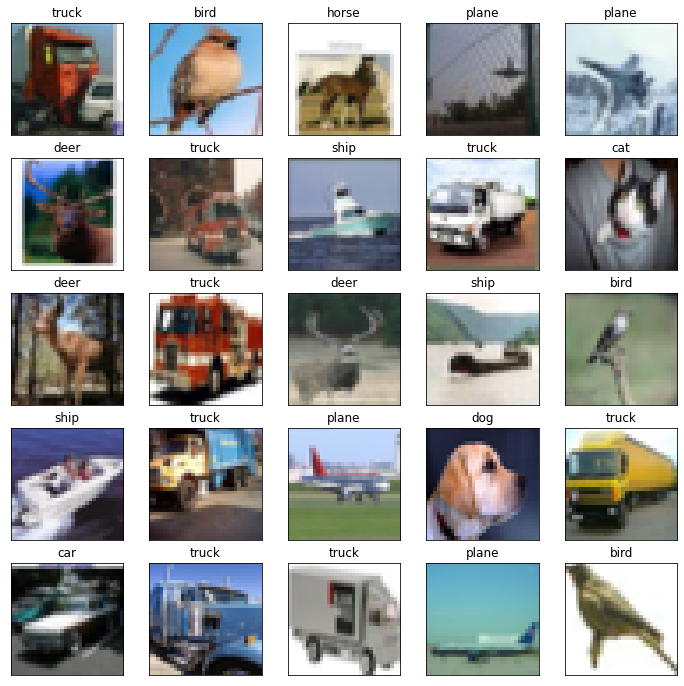

In [31]:
images, labels = next(iter(train_loader))
fig = plt.figure(figsize=(12, 12)) 

for idx in np.arange(25):
    ax = fig.add_subplot(5, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(tensor_to_img(images[idx]))
    ax.set_title(CLASSES[labels[idx].item()])

# Model

In [14]:
from torch import nn
from torch.nn import functional as F

In [15]:
nn.Conv2d(
    in_channels=3, # RGB картинка
    out_channels=6, # 6 выходных карт признаков
    kernel_size=(3, 3), # размер свертки
    stride=1, # шаг
    padding=1, # паддинг к исходному изображению(тензору)
)

Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [103]:
# https://en.wikipedia.org/wiki/LeNet
class LeNet(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5) # 3х32х32 -> 6х28x28 (свертка съела по 2 px по краям)
        self.pool1 = nn.MaxPool2d((2, 2)) # 6х28x28 -> 6х14x14
        
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5) # 6х14x14 -> 16х10x10
        self.pool2 = nn.MaxPool2d((2, 2)) # 16х10x10 -> 16х5x5
        
        self.fc1 = nn.Linear(16*5*5, 120) # тут распрямляем "картинку" 5х5 из 16 каналов в вектор и дальше обычная сетка
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)
    
    def __str__(self):
        return 'LeNet'

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.flatten(1, -1) # 1, -1 значит оставить первую ось на месте, а все остальные выпрямить (ch*h*w)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

In [104]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(AlexNet, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
    
    def __str__(self):
        return 'AlexNet'

    def forward(self, x):
        x = self.cnn(x)
        x = x.flatten(1, -1)
        x = self.classifier(x)
        return x

In [235]:
class _ResNextConv(nn.Module):
    def __init__(self, in_planes, bottleneck_width=4, cardinality=32, stride=1, expansion=2):
        super(_ResNextConv, self).__init__()
        inner_width = cardinality * bottleneck_width
        self.expansion = expansion

        self.basic = nn.Sequential(
            nn.Conv2d(in_planes, inner_width, 1, stride=1, bias=False),
            nn.BatchNorm2d(inner_width),
            nn.ReLU(),
            nn.Conv2d(inner_width, inner_width, 3, stride=stride, padding=1, groups=cardinality, bias=False),
            nn.BatchNorm2d(inner_width),
            nn.ReLU(),
            nn.Conv2d(inner_width, inner_width * self.expansion, 1, stride=1, bias=False),
            nn.BatchNorm2d(inner_width * self.expansion)
        )
        self.relu = nn.ReLU()
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != inner_width * self.expansion:
            self.shortcut = nn.Conv2d(in_planes, inner_width * self.expansion, 1, stride=stride, bias=False)
        self.bn0 = nn.BatchNorm2d(self.expansion * inner_width)
        
    def forward(self, x):
        out = self.basic(x)
        out += self.shortcut(x)
        out = self.relu(self.bn0(out))
        return out

In [244]:
class ResNeXt(nn.Module):
    def __init__(self, num_blocks, strides, cardinality, bottleneck_width, in_planes=32, expansion=2, in_channels=3, num_classes=NUM_CLASSES):
        super(ResNeXt, self).__init__()
        self.cardinality = cardinality
        self.bottleneck_width = bottleneck_width
        self.in_planes = in_planes
        self.expansion = expansion
        
        self.conv0 = nn.Conv2d(in_channels, self.in_planes, kernel_size=3, stride=1, padding=1)
        self.bn0 = nn.BatchNorm2d(self.in_planes)

        layers = []
        self.reduction = np.array([1, 1])
        assert len(strides) == len(num_blocks)
        for stride, num in zip(strides, num_blocks):
            layers.append(
                self._make_layer(num, stride)
            )
            self.reduction *= stride
        
        self.body = nn.Sequential(*layers)
        self.classifier = nn.Sequential(
            nn.Linear(self.out_features, num_classes),
        )
    
    def __str__(self):
        return 'ResNeXt'
        
    def forward(self, x):
        x = F.relu(self.bn0(self.conv0(x)))
        x = self.body(x)
        x = x.flatten(1, -1)
        x = self.classifier(x)
        return x

    def _make_layer(self, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(_ResNextConv(self.in_planes, self.bottleneck_width, self.cardinality, stride, self.expansion))
            self.in_planes = self.expansion * self.bottleneck_width * self.cardinality
            self.out_features = self.in_planes
        self.bottleneck_width *= 2
        return nn.Sequential(*layers)

In [245]:
    num_blocks=[2, 2, 2, 2, 2],
    strides=[(2, 2), (2, 2), (2, 2), (2, 2), (2, 2)],
    cardinality=2,
    bottleneck_width=2,
    expansion=2,
    in_planes=16,

In [246]:
resnext = ResNeXt(
    num_blocks=[2, 2, 2, 2, 2],
    strides=[(2, 2), (2, 2), (2, 2), (2, 2), (2, 2)],
    cardinality=4,
    bottleneck_width=2,
    expansion=2,
    in_planes=16,
)

In [247]:
summary(resnext, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
            Conv2d-3            [-1, 8, 32, 32]             128
       BatchNorm2d-4            [-1, 8, 32, 32]              16
              ReLU-5            [-1, 8, 32, 32]               0
            Conv2d-6            [-1, 8, 16, 16]             144
       BatchNorm2d-7            [-1, 8, 16, 16]              16
              ReLU-8            [-1, 8, 16, 16]               0
            Conv2d-9           [-1, 16, 16, 16]             128
      BatchNorm2d-10           [-1, 16, 16, 16]              32
           Conv2d-11           [-1, 16, 16, 16]             256
      BatchNorm2d-12           [-1, 16, 16, 16]              32
             ReLU-13           [-1, 16, 16, 16]               0
     _ResNextConv-14           [-1, 16,

In [85]:
summary(LeNet(), (3, 32, 32)) #где -1 это батчсайз в Output Shape

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

In [177]:
def train_fn(model: torch.nn.Module,
             data_loader: DataLoader,
             optimizer: torch.optim,
             compute_loss=nn.CrossEntropyLoss(),
             ) -> float:
    """train fn

    Args:
        model (torch.nn.Module): trainable model
        data_loader (Dataloader)
        optimizer (torch.optim)

    Returns:
        float: total loss on dataloader
    """
    model.train()
    total_loss = 0
    total_preds = []
    total_gt = []
    
    tk = tqdm(data_loader, total=len(data_loader))
    for images, labels in tk:
        optimizer.zero_grad()
        preds = model(images)
        loss = compute_loss(preds, labels)
        loss.backward()
        optimizer.step()

        tk.set_description('loss: ' + str(loss.item()))

        total_loss += loss.item()
        
        total_preds.append(preds)
        total_gt.append(labels)

    return total_preds, total_gt, total_loss / len(data_loader)

In [178]:
def eval_fn(model: torch.nn.Module,
        data_loader: DataLoader,
        compute_loss=nn.CrossEntropyLoss(),
            ) -> Tuple[List[torch.Tensor], List[torch.Tensor], float]:
    """model evaluation

    Args:
        model (torch.nn.Module)
        data_loader (DataLoader)

    Returns:
        Tuple[
            List[torch.Tensor], : ground true labels
            List[torch.Tensor], : prediction matrecies
            float: total loss on dataloder
        ]
    """
    model.eval()
    total_loss = 0
    total_preds = []
    total_gt = []

    tk = tqdm(data_loader, total=len(data_loader))
    for images, labels in tk:
        with torch.no_grad():
            preds = model(images)
            loss = compute_loss(preds, labels)
            total_loss += loss.item()

            total_preds.append(preds)
            total_gt.append(labels)

    return total_preds, total_gt, total_loss / len(data_loader)

In [179]:
DEVICE = 'cpu'
LOGDIR = 'output'
SAVE_INTERVAL = 5
VERBOSE = 2000

In [180]:
EPOCHS = 10

In [181]:
model = LeNet().to(DEVICE)

In [182]:
loss_fn = nn.CrossEntropyLoss()

In [186]:
def get_accuracy(pred, gt, test_loader=test_loader, classes=CLASSES, device=DEVICE):
    top_pred = pred.argmax(1, keepdim=True)
    correct = top_pred.eq(gt.view_as(top_pred)).sum()
    acc = correct.float() / gt.shape[0]
    return acc

In [187]:
def extended_accuracy(model, test_loader=test_loader, classes=CLASSES, device=DEVICE):

    class_correct = [.0 for i in range(len(classes))]
    class_total = [.0 for i in range(len(classes))]

    with torch.no_grad():
        for (images, labels) in test_loader:
            y_pred = model(images.to(device))
            _, predicted = torch.max(y_pred, 1)
            c = (predicted.cpu().detach() == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    
    for i in range(len(classes)):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))
    return np.mean([class_correct[i] / class_total[i] for i in range(len(classes))])
    

In [188]:
os.makedirs(Path(LOGDIR).parent, exist_ok=True)
os.makedirs(Path(os.path.join(LOGDIR, str(model))), exist_ok=True)
os.makedirs(Path(os.path.join(LOGDIR, str(model), 'weights')), exist_ok=True)

In [201]:
def train(model,
          epochs=EPOCHS,
          train_loader=train_loader,
          test_loader=test_loader,
          optim_cls=torch.optim.Adam,
          lr=1e-3,
          loss_fn=nn.CrossEntropyLoss(),
          save_interval=SAVE_INTERVAL,
          verbose=VERBOSE,
         ):
    best_loss = np.inf
    result = dict({
        'train_loss': [],
        'val_loss': [],
        'train_accuracy': [],
        'val_accuracy': [],
    })
    os.makedirs(Path(os.path.join(LOGDIR, str(model))), exist_ok=True)
    os.makedirs(Path(os.path.join(LOGDIR, str(model), 'weights')), exist_ok=True)
    optim = optim_cls(model.parameters(), lr=lr)
    for epoch in tqdm(range(epochs)):

        train_pred, train_gt, train_loss = train_fn(model, train_loader, optim, compute_loss=loss_fn)
        val_pred, val_gt, val_loss = eval_fn(model, test_loader, compute_loss=loss_fn)
        
        result['train_loss'].append(train_loss)
        result['val_loss'].append(val_loss)
        
        
        if epoch % save_interval == 0:
            torch.save(
                model.state_dict(), 
                f'{LOGDIR}/{str(model)}/weights/{epoch}'
            )

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(
                model.state_dict(),
                f'{LOGDIR}/{str(model)}/weights/best'
            )
            try:
                s = torch.jit.script(model)
                s.save(f'{LOGDIR}/{str(model)}/best_model.script')
            except:
                pass


        train_accuracy = np.mean([get_accuracy(pred, gt) for pred, gt in zip(train_pred, train_gt)])
        val_accuracy = np.mean([get_accuracy(pred, gt) for pred, gt in zip(val_pred, val_gt)])
        
        result['train_accuracy'].append(train_accuracy)
        result['val_accuracy'].append(val_accuracy)
    
    model.load_state_dict(torch.load(f'{LOGDIR}/{str(model)}/weights/best'))
    model.eval()
    return model, result

In [204]:
model, res = train(LeNet(), epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

In [248]:
model2, res2 = train(resnext, epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

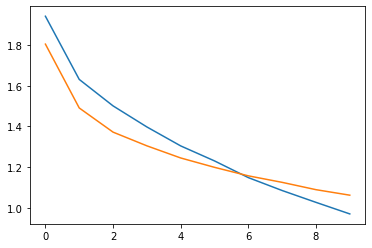

In [257]:
plt.plot(res2['train_loss'])
plt.plot(res['train_loss'])

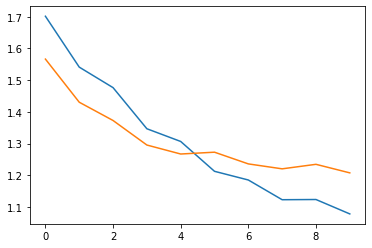

In [256]:
plt.plot(res2['val_loss'])
plt.plot(res['val_loss'])

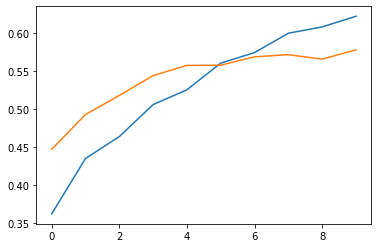

In [258]:
plt.plot(res2['val_accuracy'])
plt.plot(res['val_accuracy'])

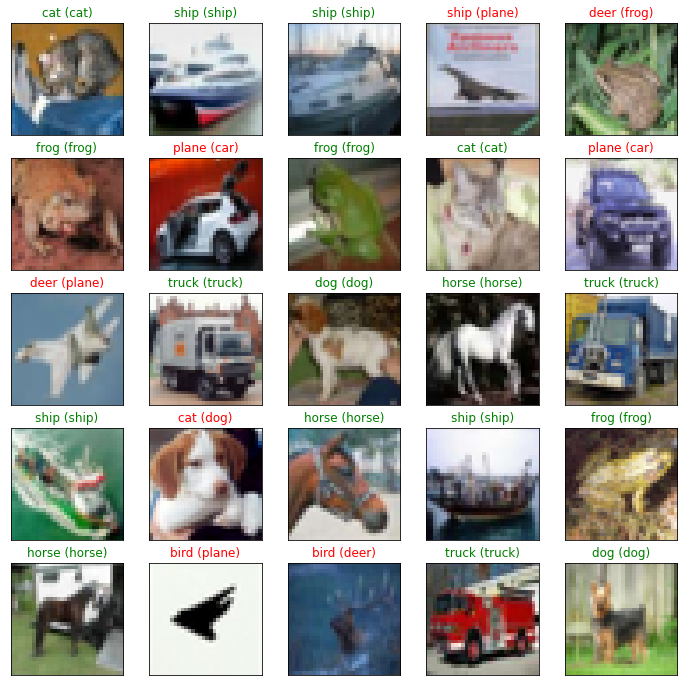

In [254]:
images, labels = next(iter(test_loader))
images = images.to(DEVICE)
labels = labels.to(DEVICE)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(12, 12)) 

for idx in np.arange(25):
    ax = fig.add_subplot(5, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(tensor_to_img(images[idx]))
    ax.set_title("{} ({})".format(str(CLASSES[preds[idx].item()]), str(CLASSES[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))
    